### Necessary imports

In [41]:
# necessary imports
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Load Pictures

In [42]:
data_dir = 'flowers'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

### Show some simples from data

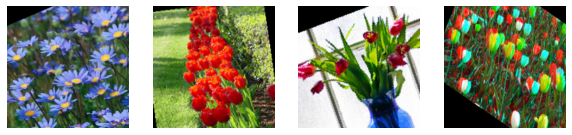

In [43]:
# Run this to test your data loader
import helper
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

### Download And Show pretrained model 

In [44]:
model = models.densenet121(pretrained=True)
# model

### Freeze pretrainid models Prametere

In [45]:
for param in model.parameters():
    param.requires_grad = False

### Change Classifier Of Pretrained Model For our Project

### Use a pretrained model to classify the flower images

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Run Model

In [47]:
epochs = 1
steps = 0
running_loss = 0
print_every = 1
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1        
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    test_loss += batch_loss.item()                   
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.705.. Test loss: 0.493.. Test accuracy: 0.750
Epoch 1/1.. Train loss: 0.313.. Test loss: 1.498.. Test accuracy: 0.500
